In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import itertools
import matplotlib
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 300;
from scipy.stats import qmc

desiredTotalCFDCases = 500
inputParamNames = [
    'deformationMode',
    'mach',
    'reynolds',
    'freestreamTemp',
    #### all variables below this line will zero when deformation mode == 0 ###
    'lengthFromFlare',
    'deformationLength',
    'deformationAmplitude'
]

l_bounds = [3, 9e4, 80, 0, 19, 1]
u_bounds = [8, 1e6, 150, 2, 76, 4]

deformationModes = [-2,-1,0,1,2] #user defined deformation modes 
numCasesPerMode = desiredTotalCFDCases/len(deformationModes) # divide CFD case budget by the number of def modes 
seedBaseNumbers = np.arange(0,len(deformationModes)) # create numpy array for LDS seed. seed ensures repeatability 
seedList = [base for base in seedBaseNumbers] #turns np array in list
deformationModesZeroIndex = np.where(np.asarray(deformationModes)==0)[0][0] # finds the index where deformation mode == 0. 
locationOfLengthFromFlare = np.where(np.asarray(inputParamNames)=='lengthFromFlare')[0][0] # finds the index where "length from flare" is in the inputParamsNames list
boundaryModIndex = locationOfLengthFromFlare - 1 # subtracting 1 from the previous index, since we're removing the deformation mode from the upper and lower bounds list 
zerosArrayDimension = len(l_bounds) - boundaryModIndex # the "rest" of the input variables, which we'll set to zero when the deformation mode is zero.

m = math.log2(numCasesPerMode)
m = math.ceil(m)

printDict = {
    True: 'HAVE',
    False: 'HAVE NOT'
}

def is_power_of_two(number : int) -> bool:
    while number != 1:
        if number % 2:
            return False
        number /= 2
    return True

powerBool = is_power_of_two(number=numCasesPerMode) # creates boolean if the number of cases creates a power of 2 for the low discrepancy sequence  

print(f'You {printDict[powerBool]} selected a power of 2 for number of cases.') 
if not powerBool:
    print(f'Based on your desired number of CFD cases, you\'ll need to run {(2**m)*len(deformationModes)} cases to safely use LDS. \nTo run less cases, you could instead run {(2**(m-1))*len(deformationModes)} CFD cases\nTo run more cases, you could instead run {(2**(m+1))*len(deformationModes)} CFD cases\n')

for i, seed in enumerate(seedList):
    if seed == seedList[deformationModesZeroIndex]: 
        l_bounds_mod = l_bounds[:boundaryModIndex] #removing the 'length from flare' and 'deformation length'
        u_bounds_mod = u_bounds[:boundaryModIndex] #removing the 'length from flare' and 'deformation length'
        sampler = qmc.Sobol(d=len(l_bounds_mod), scramble=False,seed = seed)
        sample = sampler.random_base2(m=m)
        print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')
        sample = qmc.scale(sample, l_bounds_mod, u_bounds_mod)
        tiledModes = np.tile(deformationModes[i], 2**m).reshape(-1,1)
        stackedSample = np.hstack((tiledModes,sample))
        zerosArray = np.zeros(shape=(2**m, zerosArrayDimension))
        stackedSample = np.hstack((stackedSample,zerosArray))
    else:
        sampler = qmc.Sobol(d=len(l_bounds), scramble=False,seed = seed)
        sample = sampler.random_base2(m=m)
        print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')
        sample = qmc.scale(sample, l_bounds, u_bounds)
        tiledModes = np.tile(deformationModes[i], 2**m).reshape(-1,1)
        stackedSample = np.hstack((tiledModes,sample))

    if i ==0:
        sampleArray = stackedSample
    else: 
        sampleArray = np.concatenate((sampleArray, stackedSample))

new_data=np.array([
    [2, 4, 5e5, 128, 1, 38, 2],
    [1, 4, 5e5, 128, 1, 38, 2],
    [-2, 4, 5e5, 128, 1, 38, 2],
    [-1, 4, 5e5, 128, 1, 38, 2],
    [0, 4, 5e5, 128, 0, 0, 0],
    [0, 7, 133000, 93.3, 0, 0, 0],
    [1, 7, 133000, 93.3, 1.2, 58, 3],
    [1, 7, 133000, 93.5, 0.86, 58, 3],
    [1, 7, 133000, 93.5, 0.5, 58, 3],
    [1, 7, 133000, 93.5, 0.1, 58, 3]
    ])

sampleArray = np.concatenate((sampleArray,new_data))

print(f'You have {sampleArray.shape[1]} number of input variables and a total of {sampleArray.shape[0]} number of cases.')
print(f'Shape of your input sample array: {sampleArray.shape}')

df = pd.DataFrame(data = sampleArray, columns = inputParamNames)
df.to_csv('./inputVariables.csv')

You HAVE NOT selected a power of 2 for number of cases.
Based on your desired number of CFD cases, you'll need to run 640 cases to safely use LDS. 
To run less cases, you could instead run 320 CFD cases
To run more cases, you could instead run 1280 CFD cases

discrepancy of sample: 0.0017235067807686022. seed: 0
discrepancy of sample: 0.0017235067807686022. seed: 1
discrepancy of sample: 0.00016147477845018798. seed: 2
discrepancy of sample: 0.0017235067807686022. seed: 3
discrepancy of sample: 0.0017235067807686022. seed: 4
You have 7 number of input variables and a total of 650 number of cases.
Shape of your input sample array: (650, 7)


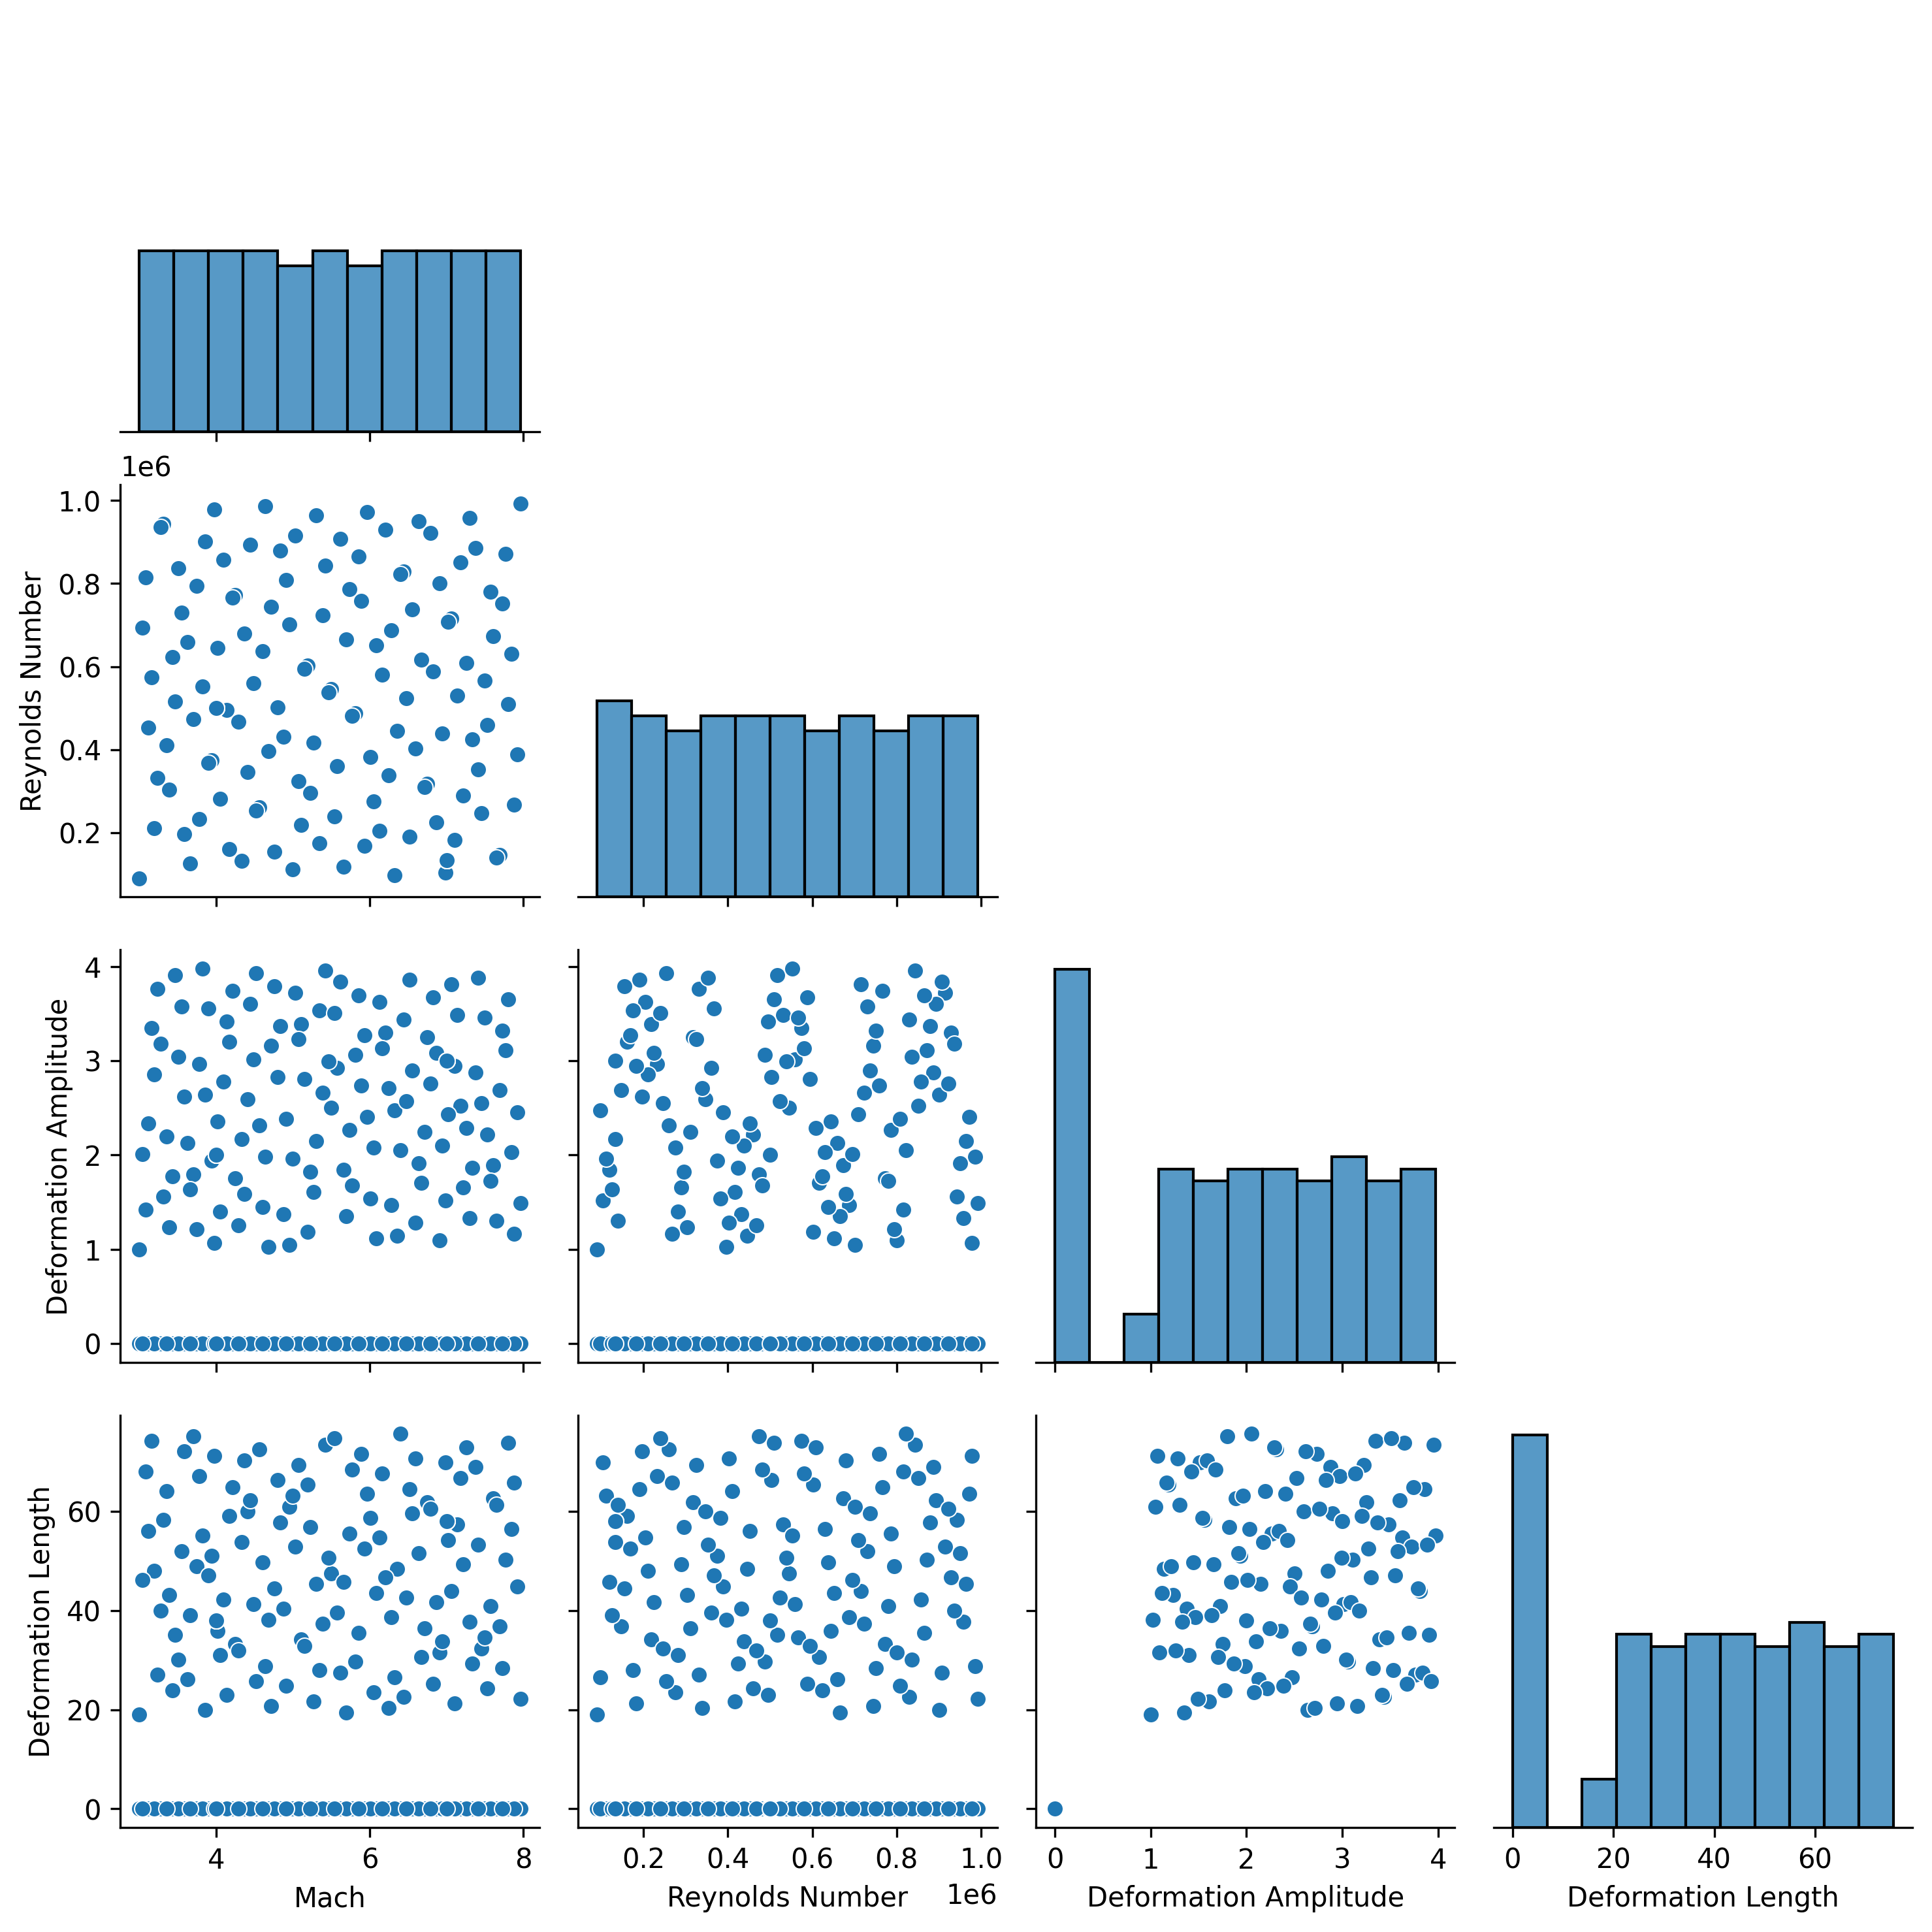

In [8]:
# locationFromFlareDF = pd.DataFrame(data = sampleArray[:,locationOfLengthFromFlare])
# sns.histplot(locationFromFlareDF)
# sns.set(font_scale=1)
selectedVariables = ['mach', 'reynolds', 'deformationAmplitude', 'deformationLength']

columnRenameDict = {
    'mach': 'Mach',
    'reynolds': 'Reynolds Number',
    'deformationAmplitude': 'Deformation Amplitude',
    'deformationLength': 'Deformation Length'
}

df_new = df[selectedVariables]
df_new = df_new.rename(columns=columnRenameDict)
sns.pairplot(df_new, corner=True)

In [17]:
-(469.5000*Kt*Kw*lBar)/(pi*cos(lambda)*(1700*Kt*cBar*sin(lambda) - 939*Kw*S*eBar*lBar*cos(lambda)))

SyntaxError: invalid syntax (1458300031.py, line 1)

AttributeError: 'bytes' object has no attribute 'shape'

In [16]:
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'maxcurv1', 'maxcurv1location', 'maxcurv2', 'maxcurv2location', 'maxdef', 'maxdeflocation', 'maxslope1', 'maxslope1location', 'maxslope2', 'maxslope2location', 'mincurv1', 'mincurv1location', 'mincurv2', 'mincurv2location', 'mindef', 'mindeflocation', 'minslope1', 'minslope1location', 'minslope2', 'minslope2location'])


In [21]:
for key in mat.keys():
    print(mat[key].shape)

(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)
(1, 650)


In [20]:
mat.keys()

dict_keys(['maxcurv1', 'maxcurv1location', 'maxcurv2', 'maxcurv2location', 'maxdef', 'maxdeflocation', 'maxslope1', 'maxslope1location', 'maxslope2', 'maxslope2location', 'mincurv1', 'mincurv1location', 'mincurv2', 'mincurv2location', 'mindef', 'mindeflocation', 'minslope1', 'minslope1location', 'minslope2', 'minslope2location'])

In [23]:
import scipy.io
mat = scipy.io.loadmat('defslopecurv.mat')

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

delKeysList = ['__header__', '__version__', '__globals__']
for key in delKeysList:
    mat = removekey(mat,key)

aaronDF = pd.DataFrame.from_dict(mat,orient='index')

ValueError: Must pass 2-d input. shape=(20, 1, 650)